<a href="https://colab.research.google.com/github/Nebil1/UNDP-FTL-AI/blob/main/Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Install & Import Libraries

In [167]:
!pip install pandas scikit-learn matplotlib seaborn

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, roc_curve, auc)

##Load the Data

In [169]:
file_url = "https://drive.google.com/uc?id=1zIk9JOdJEu9YF7Xuv2C8f2Q8ySfG3nHd"
df = pd.read_csv(file_url)

In [170]:
print("Starting shape:", df.shape)
df.head()

Starting shape: (165, 14)


,Country or Administrative area,Area [km2],Coast length [km],Rainfall [mm year -1],Factor L/A [-],Factor (L/A) *P [-],P[E] [%],MPW (metric tons year -1),M[E] (metric tons year -1),Ratio Me/MPW,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,Albania,28'486,362,1'117,0.0100,14.0,1.56%,69'833,1'565,2.24%,NaN,NaN,NaN,NaN
1,Algeria,2'316'559,998,80,0.0004,0.0,0.09%,764'578,5'774,0.76%,NaN,NaN,NaN,NaN
2,Angola,1'247'357,1'600,1'025,0.0010,1.0,0.09%,236'946,860,0.36%,NaN,NaN,NaN,NaN
3,Antigua and Barbuda,443,153,996,0.3000,344.0,3.08%,627,2,0.29%,NaN,NaN,NaN,NaN
4,Argentina,2'779'705,4'989,567,0.0020,1.0,0.26%,465'808,4'137,0.89%,NaN,NaN,NaN,NaN


Count missing per column

In [171]:
missing_counts = df.isna().sum()
print(missing_counts)

Country or Administrative area      2
Area [km2]                          2
Coast length [km]                   2
Rainfall [mm year -1]               2
Factor L/A [-]                      2
Factor (L/A) *P [-]                 2
P[E] [%]                            2
MPW (metric tons year -1)           2
M[E] (metric tons year -1)          2
Ratio Me/MPW                        2
Unnamed: 10                       165
Unnamed: 11                       165
Unnamed: 12                       165
Unnamed: 13                       165
dtype: int64


## Drop empty “Unnamed” columns


In [172]:
df = df.drop(columns=[c for c in df.columns if c.startswith("Unnamed")])
print("After dropping empty columns:", df.shape)

After dropping empty columns: (165, 10)


##Clean the dataset

In [173]:
# 2) Helper to strip symbols → float
def clean_numeric(col):
    return (
        col.astype(str)
           .str.replace(r'[^0-9.\-]', '', regex=True)
           .replace('', np.nan)
           .astype(float)
    )

In [174]:
# 3) Clean percent‐style and unit‐columns
for c in ['P[E] [%]', 'Ratio Me/MPW', 'Area [km2]', 'Coast length [km]', 'Rainfall [mm year-1]']:
    if c in df.columns:
        df[c] = clean_numeric(df[c])

In [175]:
# 4) Clean & convert the main target column of interest
col = 'M[E] (metric tons year -1)'
# ── remove apostrophes, commas, spaces, etc. ──
df[col] = (
    df[col]
      .astype(str)
      .str.replace(r"[^0-9.\-]", "", regex=True)
)

In [176]:
# ── now convert to numeric, bad values → NaN ──
df[col] = pd.to_numeric(df[col], errors='coerce')

In [177]:
# 5) Impute any remaining NaNs via a 5‐row rolling mean
numeric_cols = df.select_dtypes(include=[np.number]).columns
for c in numeric_cols:
    roll = df[c].rolling(window=5, center=True, min_periods=1).mean()
    df[c].fillna(roll, inplace=True)

##Label Creation

In [178]:
# 6) Create binary label: 0 = high polluter (>6008), 1 = low polluter (≤6008)
df['plastic_contribution'] = (df[col] <= 6008).astype(int)

##Features & target

In [179]:
# 7) Build feature matrix X and target y
X = df.drop([col, 'plastic_contribution', 'Country or Administrative area'], axis=1, errors='ignore')
X = X.select_dtypes(include=[np.number])
y = df['plastic_contribution']

##Train/Test Split
- Split X and y into training (80%) and test (20%) sets,
- Splits your dataset so the model only “sees” 80% of the data during training.
- The remaining 20% is kept completely unseen until evaluation.
-Keeps the proportion of high-/low-polluter examples the same in both train and test sets.

In [180]:
# 8) Split into train/test, stratifying on y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [181]:
print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)
print("y_train balance:\n", y_train.value_counts(normalize=True))
print("y_test  balance:\n", y_test.value_counts(normalize=True))

X_train shape: (132, 6)
X_test  shape: (33, 6)
y_train balance:
 plastic_contribution
1    0.901515
0    0.098485
Name: proportion, dtype: float64
y_test  balance:
 plastic_contribution
1    0.909091
0    0.090909
Name: proportion, dtype: float64


##Feature Scaling
- .fit_transform(X_train) computes each feature’s mean & standard deviation on the training data and scales it (mean→0, std→1)
- .transform(X_test) applies t

- Prevents features with large numeric ranges from dominating the model.
- Ensures your test set is scaled consistently with the training set.

In [182]:
# Create a scaler object
scaler = StandardScaler()

# 1) Fit on training data and transform it:
X_train_scaled = scaler.fit_transform(X_train)

# 2) Transform test data using the same scaler:
X_test_scaled  = scaler.transform(X_test)

In [183]:
print("Feature means (train):", X_train_scaled.mean(axis=0))
print("Feature stds  (train):", X_train_scaled.std(axis=0))

Feature means (train): [-3.36431220e-18 -3.36431220e-17  1.68215610e-17 -1.51394049e-17
 -3.36431220e-17 -1.21115239e-16]
Feature stds  (train): [1. 1. 1. 1. 1. 1.]


In [184]:
print(df['plastic_contribution'].value_counts())

plastic_contribution
1    149
0     16
Name: count, dtype: int64


##Train Logistic Regression model
- .fit(X_train_scaled, y_train)
    - Tells the algorithm to learn the relationship between your input features (X_train_scaled) and their labels (y_train).
    - After this step, model has “seen” the training examples and stored the learned coefficients.

In [185]:
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

##Evaluating the Model

Use the trained model to make predictions on unseen test data

In [186]:
y_pred = model.predict(X_test_scaled)


In [187]:
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy : 0.9090909090909091
Precision: 0.9090909090909091
Recall   : 1.0

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.91      1.00      0.95        30

    accuracy                           0.91        33
   macro avg       0.45      0.50      0.48        33
weighted avg       0.83      0.91      0.87        33



##visual

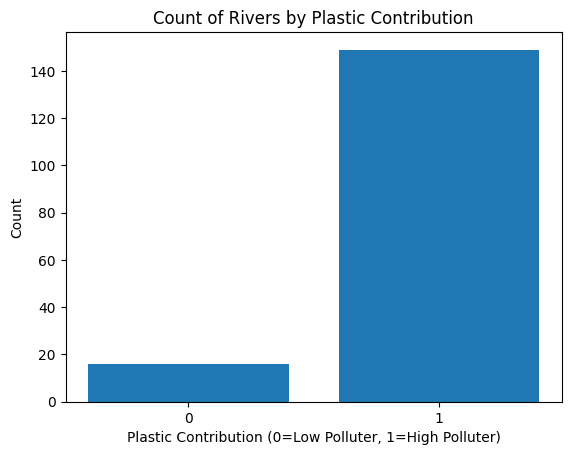

In [188]:
# 1) Count vs. plastic_contribution
plt.figure()
counts = df['plastic_contribution'].value_counts().sort_index()
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel('Plastic Contribution (0=Low Polluter, 1=High Polluter)')
plt.ylabel('Count')
plt.title('Count of Rivers by Plastic Contribution')
plt.show()

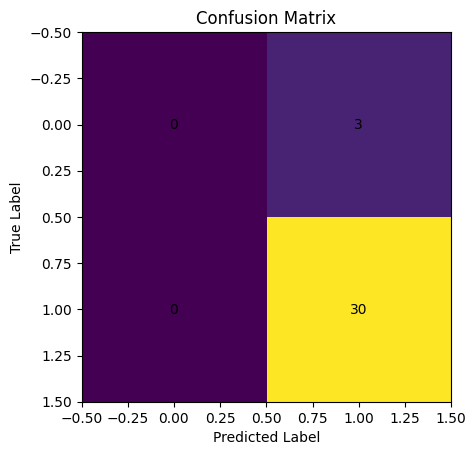

In [189]:
# 2) Confusion Matrix
y_pred = model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm)
for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, str(val), ha='center', va='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

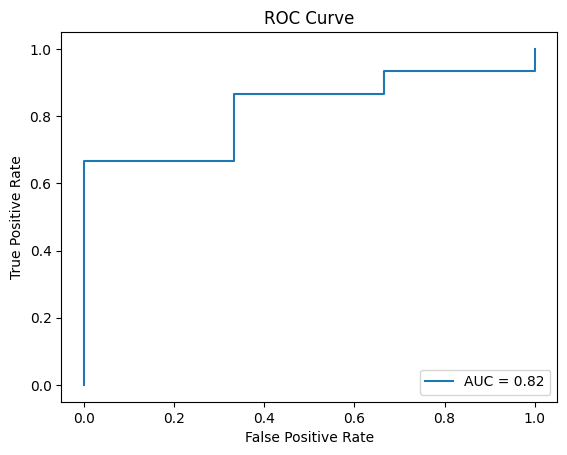

In [190]:
# 3) ROC Curve and AUC
y_score = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()